Goal of this notebook is to mix SCIN with fitzpatrick17k for top 9 conditions present in the SCIN.

Here are tentative steps:
* Load SCIN metadata
* Load SCIN Embeddings
* Prepare SCIN
* Read fitzpatrick CSV having embeddings
* Merge embeddings from SCIN and fitzpatrick
* train initial model and see results
* continue with optuna to find best model


In [9]:
import collections
import io
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.metrics import classification_report


import tensorflow as tf

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Authenticate to Access Data
The following cell is for Colab only. If running elsewhere, authenticate with the [gcloud CLI](https://cloud.google.com/sdk/gcloud/reference/auth/login).

In [12]:
from google.colab import auth
from google.cloud import storage

# Authenticate user for access. There will be a popup asking you to sign in with your user and approve access.
auth.authenticate_user()

# Authenticate user for HuggingFace if needed. Enter token below if requested.
from huggingface_hub.utils import HfFolder
from huggingface_hub import notebook_login

if HfFolder.get_token() is None:
    from huggingface_hub import notebook_login
    notebook_login()

# Load SCIN Dataset and Pre-computed Embeddings

Since it takes ~hours to generate the embeddings we will dowload some pre-computed ones from HuggingFace. If you would like to generate your own see HuggingFace model card.

In [13]:
# Load SCIN Dataset

SCIN_GCP_PROJECT = 'dx-scin-public'
SCIN_GCS_BUCKET_NAME = 'dx-scin-public-data'
SCIN_GCS_CASES_CSV = 'dataset/scin_cases.csv'
SCIN_GCS_LABELS_CSV = 'dataset/scin_labels.csv'
SCIN_GCS_IMAGES_DIR = 'dataset/images/'


def initialize_df_with_metadata(bucket, csv_path):
  """Loads the given CSV into a pd.DataFrame."""
  df = pd.read_csv(io.BytesIO(bucket.blob(csv_path).download_as_string()), dtype={'case_id': str})
  df['case_id'] = df['case_id'].astype(str)
  return df

def augment_metadata_with_labels(df, bucket, csv_path):
  """Loads the given CSV into a pd.DataFrame."""
  labels_df = pd.read_csv(io.BytesIO(bucket.blob(csv_path).download_as_string()), dtype={'case_id': str})
  labels_df['case_id'] = labels_df['case_id'].astype(str)
  merged_df = pd.merge(df, labels_df, on='case_id')
  return merged_df

scin_bucket = storage.Client(SCIN_GCP_PROJECT).bucket(SCIN_GCS_BUCKET_NAME)

scin_no_label_df = initialize_df_with_metadata(scin_bucket, SCIN_GCS_CASES_CSV)
scin_df = augment_metadata_with_labels(scin_no_label_df, scin_bucket, SCIN_GCS_LABELS_CSV)
scin_df.set_index('case_id', inplace=True)
print(f'Loaded {len(scin_df)} rows.')

# scin_df is the main data frame we will be working with.
scin_df.head(5)

Loaded 5033 rows.


,source,release,year,age_group,sex_at_birth,fitzpatrick_skin_type,race_ethnicity_american_indian_or_alaska_native,race_ethnicity_asian,race_ethnicity_black_or_african_american,race_ethnicity_hispanic_latino_or_spanish_origin,...,dermatologist_gradable_for_fitzpatrick_skin_type_1,dermatologist_gradable_for_fitzpatrick_skin_type_2,dermatologist_gradable_for_fitzpatrick_skin_type_3,dermatologist_fitzpatrick_skin_type_label_1,dermatologist_fitzpatrick_skin_type_label_2,dermatologist_fitzpatrick_skin_type_label_3,gradable_for_monk_skin_tone_india,gradable_for_monk_skin_tone_us,monk_skin_tone_label_india,monk_skin_tone_label_us
case_id,,,,,,,,,,,,,,,,,,,,,
-1000600354148496558,SCIN,1.0.0,2023,AGE_UNKNOWN,OTHER_OR_UNSPECIFIED,NaN,NaN,NaN,NaN,NaN,...,YES,NaN,NaN,FST2,NaN,NaN,True,True,2.0,1.0
-1002039107727665188,SCIN,1.0.0,2023,AGE_UNKNOWN,OTHER_OR_UNSPECIFIED,NaN,NaN,NaN,NaN,NaN,...,YES,NaN,NaN,FST1,NaN,NaN,True,True,3.0,3.0
-1003358831658393077,SCIN,1.0.0,2023,AGE_18_TO_29,MALE,NONE_IDENTIFIED,NaN,NaN,NaN,YES,...,YES,NaN,NaN,FST4,NaN,NaN,True,True,3.0,4.0
-1003826561155964328,SCIN,1.0.0,2023,AGE_UNKNOWN,OTHER_OR_UNSPECIFIED,NaN,NaN,NaN,NaN,NaN,...,NO,NaN,NaN,NaN,NaN,NaN,True,True,2.0,4.0
-1003844406100696311,SCIN,1.0.0,2023,AGE_40_TO_49,FEMALE,FST3,NaN,NaN,NaN,NaN,...,YES,NaN,NaN,FST1,NaN,NaN,True,True,1.0,1.0


In [14]:
scin_df['dermatologist_skin_condition_on_label_name'] = scin_df['dermatologist_skin_condition_on_label_name'].str.lower()
scin_df['dermatologist_skin_condition_on_label_name']

case_id
-1000600354148496558    ['inflicted skin lesions', 'eczema', 'irritant...
-1002039107727665188    ['prurigo nodularis', 'actinic keratosis', 'sc...
-1003358831658393077    ['impetigo', 'herpes zoster', 'bullous dermati...
-1003826561155964328                                                   []
-1003844406100696311    ['lichen planus/lichenoid eruption', 'follicul...
                                              ...                        
973759811984683137      ['cd - contact dermatitis', 'allergic contact ...
973872028150293734                                                     []
983265958160210646                           ['impetigo', 'foreign body']
995820220956352730      ['erythema gyratum repens', 'seborrheic dermat...
998890198757718998                                       ['folliculitis']
Name: dermatologist_skin_condition_on_label_name, Length: 5033, dtype: object

In [15]:
scin_df.columns

Index(['source', 'release', 'year', 'age_group', 'sex_at_birth',
       'fitzpatrick_skin_type',
       'race_ethnicity_american_indian_or_alaska_native',
       'race_ethnicity_asian', 'race_ethnicity_black_or_african_american',
       'race_ethnicity_hispanic_latino_or_spanish_origin',
       'race_ethnicity_middle_eastern_or_north_african',
       'race_ethnicity_native_hawaiian_or_pacific_islander',
       'race_ethnicity_white', 'race_ethnicity_other_race',
       'race_ethnicity_prefer_not_to_answer', 'textures_raised_or_bumpy',
       'textures_flat', 'textures_rough_or_flaky', 'textures_fluid_filled',
       'body_parts_head_or_neck', 'body_parts_arm', 'body_parts_palm',
       'body_parts_back_of_hand', 'body_parts_torso_front',
       'body_parts_torso_back', 'body_parts_genitalia_or_groin',
       'body_parts_buttocks', 'body_parts_leg', 'body_parts_foot_top_or_side',
       'body_parts_foot_sole', 'body_parts_other',
       'condition_symptoms_bothersome_appearance',
      

In [16]:
set(scin_df['fitzpatrick_skin_type'])

{'FST1', 'FST2', 'FST3', 'FST4', 'FST5', 'FST6', 'NONE_IDENTIFIED', nan}

In [17]:
# Load Precomputed Embeddings for SCIN Dataset
SCIN_HF_MODEL_NAME = 'google/derm-foundation'
SCIN_HF_EMBEDDING_FILE = 'scin_dataset_precomputed_embeddings.npz'

!pip install huggingface_hub 2>&1 1>/dev/null
from huggingface_hub import hf_hub_download
import numpy as np

def load_embeddings_from_file(repo_id, object_name):
  file_path = hf_hub_download(repo_id=SCIN_HF_MODEL_NAME, filename=object_name, local_dir='/content/')

  # Parse NPZ file
  embeddings = dict()
  with open(file_path, 'rb') as f:
      x = np.load(f, allow_pickle=True)  # Load the numpy file

      # Iterate over items if it's a .npz file (which contains multiple arrays)
      for k, v in x.items():
        embeddings[k] = v

  return embeddings

# embeddings - a dict mapping image path -> embedding
embeddings = load_embeddings_from_file(SCIN_HF_MODEL_NAME, SCIN_HF_EMBEDDING_FILE)

print(f'Loaded {len(embeddings)} embeddings.')
for k, v in embeddings.items():
  print(f'Embeddings map {k} to {v.shape}')
  break

Loaded 10379 embeddings.
Embeddings map dataset/images/-3205742176803893704.png to (6144,)


# Explore SCIN Dataset

In [18]:

COMMON_CONDITIONS_TO_PREDICT =  ['scabies',
                                 'eczema',
                                 'keratosis pilaris',
                                 'psoriasis',
                                 'urticaria',
                                 'acne',
                                 'allergic contact dermatitis',
                                 'pityriasis rosea',
                                 'folliculitis']


In [19]:
def prepare_data():
  #CONDITIONS_TO_PREDICT = ['Eczema', 'Allergic Contact Dermatitis', 'Insect Bite', 'Urticaria', 'Psoriasis', 'Folliculitis', 'Irritant Contact Dermatitis', 'Tinea', 'Herpes Zoster', 'Drug Rash', 'Herpes Simplex', 'Impetigo', 'Acute dermatitis, NOS', 'Hypersensitivity', 'Acne']
  MINIMUM_CONFIDENCE = 3

  X = []
  y = []
  poor_image_quality_counter = 0
  missing_embedding_counter = 0
  not_in_condition_to_predict_counter = 0
  condition_confidence_low_counter = 0
  count = 0

  for row in scin_df.itertuples():
    count = count + 1
    if row.dermatologist_gradable_for_skin_condition_1 != 'DEFAULT_YES_IMAGE_QUALITY_SUFFICIENT':
      poor_image_quality_counter += 1
      continue

    # eval converts from string to dict
    labels = eval(row.dermatologist_skin_condition_on_label_name)
    confidence = eval(row.dermatologist_skin_condition_confidence)

    row_labels = []
    for label, confidence in zip(labels, confidence):
      if label not in COMMON_CONDITIONS_TO_PREDICT:
        not_in_condition_to_predict_counter += 1
        continue
      if confidence < MINIMUM_CONFIDENCE:
        condition_confidence_low_counter += 1
        continue
      row_labels.append(label)



    for image_path in [row.image_1_path, row.image_2_path, row.image_3_path]:
      if pd.isna(image_path):
        continue
      if image_path not in embeddings:
        missing_embedding_counter += 1
        continue

      if len(row_labels) == 0:
        continue

      X.append(embeddings[image_path])
      y.append(row_labels)

  print(f'Coutn is: {count}')
  print(f'Poor image quality: {poor_image_quality_counter}')
  print(f'Missing embedding: {missing_embedding_counter}')
  print(f'Condition not in "COMMON_CONDITIONS_TO_PREDICT": {not_in_condition_to_predict_counter}')
  print(f'Exluded label confidence too low: {condition_confidence_low_counter}')
  return X, y


X, y = prepare_data()


Coutn is: 5033
Poor image quality: 1984
Missing embedding: 1
Condition not in "COMMON_CONDITIONS_TO_PREDICT": 4612
Exluded label confidence too low: 2030


In [20]:
print(f'SIze of X: {len(X)}')
print(f'SIze of y: {len(y)}')

SIze of X: 2495
SIze of y: 2495


In [21]:
print(f'Sample X value: {X[0]}')
print(f'Sample y value: {y[1223]}')

Sample X value: [0.         0.         0.11120892 ... 0.         0.         0.02398864]
Sample y value: ['eczema', 'allergic contact dermatitis']


In [22]:
print(f'X type: {type(X)}')
print(f'y type: {type(y)}')

X type: <class 'list'>
y type: <class 'list'>


In [23]:
# Flatten the list of lists and create a set of unique labels
unique_labels = set(label for labels_list in y for label in labels_list)

print(unique_labels)
print(f'Total unique labels: {len(unique_labels)}')


{'allergic contact dermatitis', 'pityriasis rosea', 'psoriasis', 'eczema', 'scabies', 'urticaria', 'folliculitis', 'acne', 'keratosis pilaris'}
Total unique labels: 9


In [24]:
for labels in y[:5]:
    print(labels)

['eczema']
['eczema', 'eczema', 'eczema']
['eczema', 'eczema', 'eczema']
['eczema']
['eczema']


In [25]:
# Remove duplicate labels per sample
y = [list(set(label_list)) for label_list in y]

In [26]:
for labels in y[:5]:
    print(labels)

['eczema']
['eczema']
['eczema']
['eczema']
['eczema']


Distribution of conditions in "dermatologist_skin_condition_on_label_name" column:
  eczema: 1211
  allergic contact dermatitis: 952
  insect bite: 449
  urticaria: 377
  psoriasis: 348
  folliculitis: 297
  irritant contact dermatitis: 254
  tinea: 232
  herpes zoster: 157


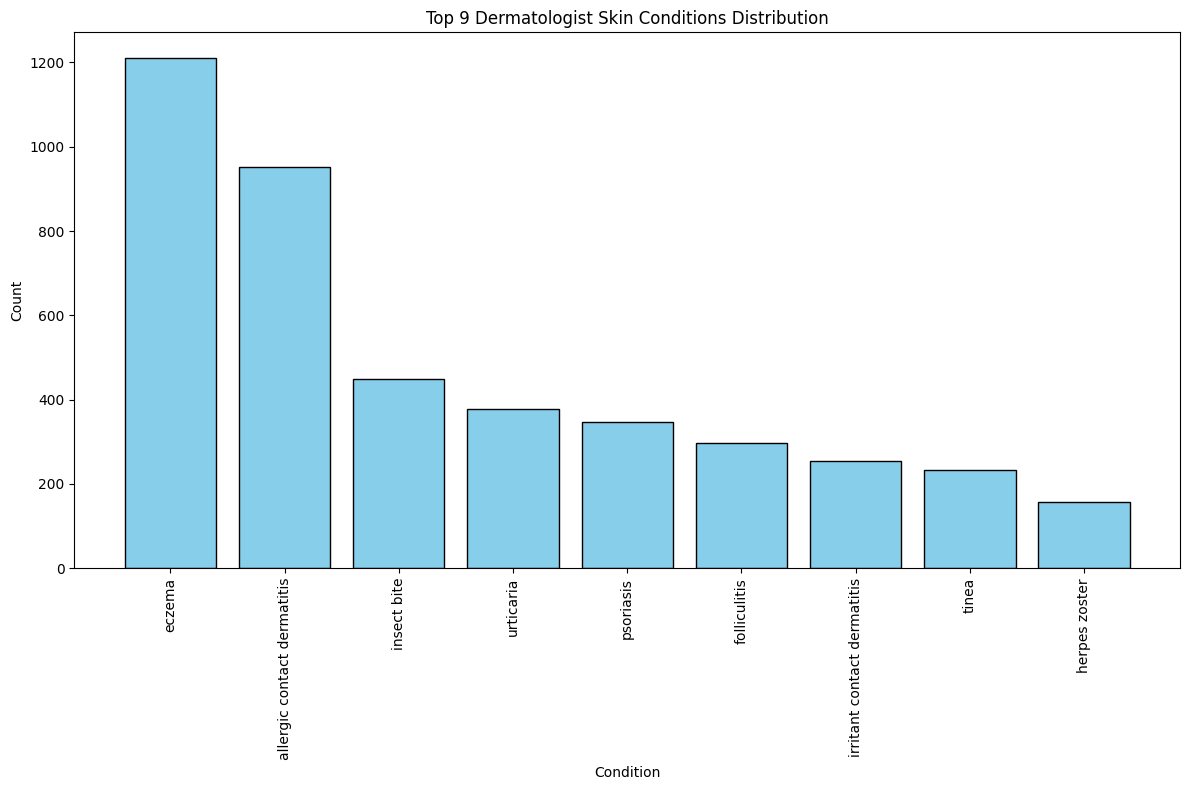

In [27]:
import collections
import matplotlib.pyplot as plt

def plot_condition_distribution(df, top_n_conditions=9):
    condition_ctr = collections.Counter()
    print(f'Distribution of conditions in "dermatologist_skin_condition_on_label_name" column:')

    # Aggregate counts of all conditions
    for entry in df['dermatologist_skin_condition_on_label_name'].dropna():
        condition_ctr.update(eval(entry))

    # Print top N conditions
    for condition, cnt in condition_ctr.most_common(top_n_conditions):
        print(f'  {condition}: {cnt}')

    # Prepare data for plotting
    top_conditions = condition_ctr.most_common(top_n_conditions)
    conditions, counts = zip(*top_conditions)

    # Plot bar chart
    plt.figure(figsize=(12, 8))
    plt.bar(range(len(conditions)), counts, color='skyblue', edgecolor='black')
    plt.xticks(range(len(conditions)), conditions, rotation=90)
    plt.xlabel('Condition')
    plt.ylabel('Count')
    plt.title(f'Top {top_n_conditions} Dermatologist Skin Conditions Distribution')
    plt.tight_layout()
    plt.show()

# Call the function with your dataframe
plot_condition_distribution(scin_df)


# Load Fitzpatrick and merge with SCIN

In [28]:
#load '/content/drive/MyDrive/Colab Notebooks/Tele_Derm_Shared/datasets/df_fitz_embeds.csv' into a data frame

# df_fitz_embeds = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Tele_Derm_Shared/datasets/df_fitz_embeds.csv')
df_fitz_embeds = pd.read_csv('/kaggle/input/fitzpatrick17k/datasets/df_fitz_embeds.csv')

In [29]:
df_fitz_embeds

,image_id,0,1,2,3,4,5,6,7,8,...,6135,6136,6137,6138,6139,6140,6141,6142,6143,labels
0,acne-infantilis2,0.012911,0.0,0.000660,0.007738,0.029158,0.0,0.008369,0.340419,0.000000,...,2.533911,0.000000,0.082253,0.148207,0.161877,0.127571,0.0,0.415417,0.029290,acne
1,parapsoriasis-large-plaque5,0.032762,0.0,0.019697,0.570982,0.015337,0.0,0.020969,0.316166,0.042224,...,0.025047,0.006145,0.014637,0.110821,0.015010,0.425963,0.0,0.000000,0.147995,psoriasis
2,pseudomonas_folliculitis7,0.000000,0.0,0.000951,0.002017,0.065212,0.0,0.001173,0.040907,0.001319,...,0.168670,0.002895,0.014733,0.057976,0.000000,1.349442,0.0,0.030078,0.003036,folliculitis
3,psoriasis72,0.000000,0.0,0.021460,0.000000,0.120495,0.0,0.020330,0.493396,0.000000,...,0.126314,0.000000,0.000000,0.030679,0.000000,0.717634,0.0,0.260650,0.160835,psoriasis
4,comedonal_acne22,0.000000,0.0,0.039576,0.692501,0.000000,0.0,0.000000,0.036202,0.054709,...,0.113808,0.000000,0.034767,0.004403,0.000000,0.681997,0.0,0.000000,0.323133,acne
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013,folliculitis53,0.025443,0.0,0.002680,1.263784,0.368606,0.0,0.000000,0.094568,0.000000,...,0.621154,0.491817,0.467248,2.208631,0.137860,1.700730,0.0,0.000000,0.006228,folliculitis
2014,red-psoriais1,0.000000,0.0,0.012741,0.001941,0.037058,0.0,0.703990,0.123378,0.000000,...,0.240148,0.000000,0.000000,0.282383,0.530146,0.463487,0.0,0.130119,0.011644,psoriasis
2015,scabies43,0.000000,0.0,0.373587,0.028785,0.000000,0.0,0.022825,0.014164,0.005274,...,2.032966,0.000000,0.132169,0.105388,1.440341,1.144488,0.0,0.041398,0.124783,scabies
2016,pseudofolliculitis-barbae14,0.240476,0.0,0.004938,4.636874,0.000000,0.0,0.022176,0.449904,0.015104,...,0.489845,0.000000,0.000000,0.584604,0.000000,0.145940,0.0,0.006460,0.240244,folliculitis


In [30]:
label_counts = df_fitz_embeds['labels'].value_counts()
print(label_counts.to_dict())

{'psoriasis': 549, 'allergic contact dermatitis': 387, 'folliculitis': 240, 'eczema': 202, 'scabies': 201, 'acne': 159, 'urticaria': 116, 'pityriasis rosea': 98, 'keratosis pilaris': 66}


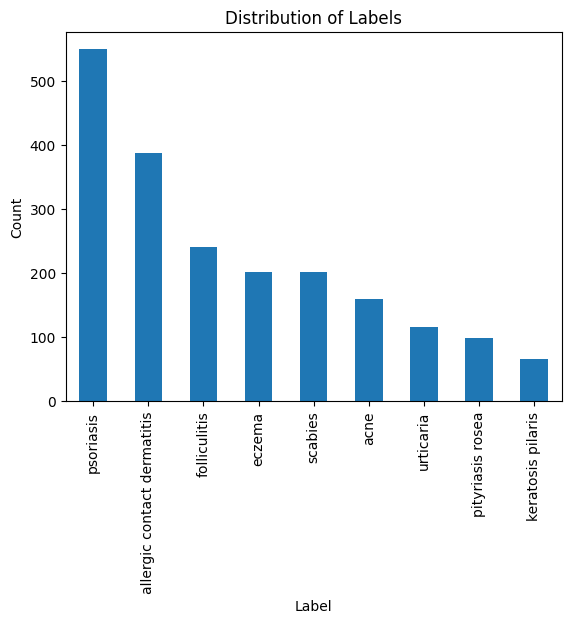

In [31]:
# Count each label
label_counts = df_fitz_embeds['labels'].value_counts()

# Plot as a bar chart
label_counts.plot(kind='bar')

# Add labels and title
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels')

# Show plot
plt.show()

In [32]:
# prepare X and y
x_fitz = df_fitz_embeds.drop(columns=['image_id', 'labels']).values
y_fitz = df_fitz_embeds['labels'].values
y_fitz = [[item] for item in y_fitz]

# Ensure y_fitz is List[List[str]]
# If it's already [[label]], just convert any non-list entries
# y_fitz_standardized = [[str(label)] if not isinstance(label, list) else label for label in y_fitz]

# merge SCIN and Fitz
X_f = np.concatenate((X, x_fitz))
y_f = y + y_fitz


In [33]:
print(len(X_f))
print(len(y_f))

4513
4513


In [34]:
print(len(X_f[0]))
print(y_f[0])

6144
['eczema']


In [35]:
print(type(X_f))
print(type(y_f))

<class 'numpy.ndarray'>
<class 'list'>


In [36]:
from collections import Counter

# Flatten list of lists into a single list
all_labels = [label for sublist in y_f for label in sublist]

# Count label frequencies
label_counts = Counter(all_labels)
label_counts


Counter({'eczema': 1243,
         'urticaria': 525,
         'pityriasis rosea': 185,
         'allergic contact dermatitis': 1000,
         'folliculitis': 496,
         'acne': 277,
         'psoriasis': 742,
         'keratosis pilaris': 147,
         'scabies': 221})

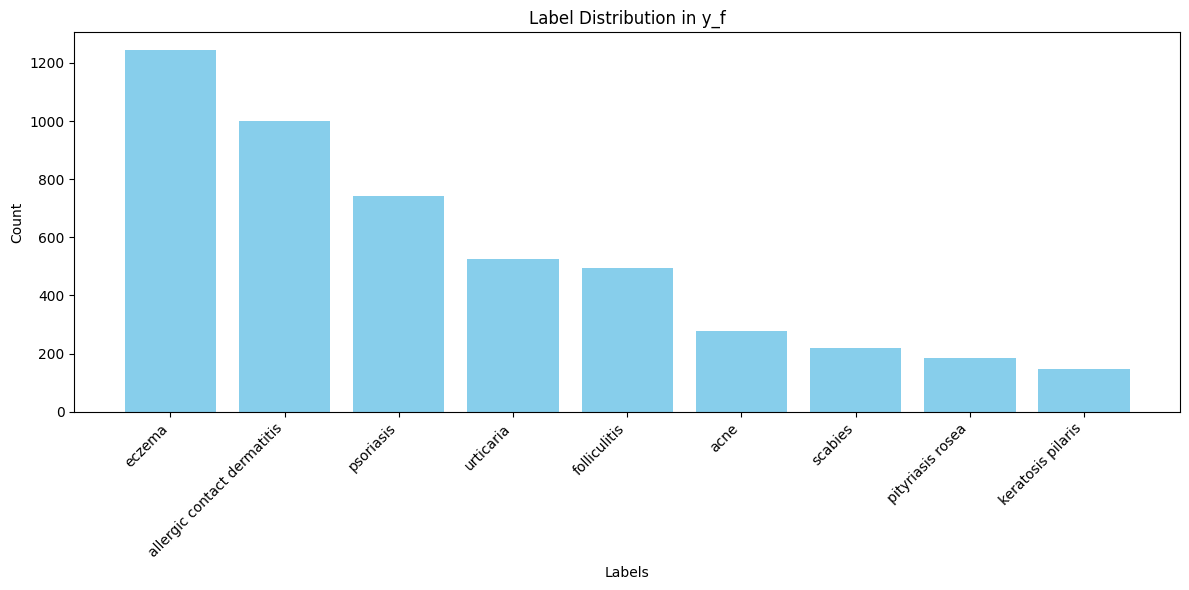

In [37]:
import matplotlib.pyplot as plt

# Sort labels by frequency
labels, counts = zip(*label_counts.most_common())

plt.figure(figsize=(12, 6))
plt.bar(labels, counts, color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.title("Label Distribution in y_f")
plt.xlabel("Labels")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


np.vstack() stacks rows (samples) on top of each other.

X_np.shape = (n1, 6144), x_fitz.shape = (n2, 6144)

Result: X_combined.shape = (n1 + n2, 6144)

In [38]:
# Convert y from [['Eczma'], ['Urticaria', 'Insect Bite']] to
# [[0 0 1 0 0 0 0 0 0 0], [0 0 0 1 1 0 0 0 0 0]]
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
y_f = mlb.fit_transform(y_f)

In [39]:
y_f[:10]

array([[0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1]])

In [40]:
mlb.classes_

array(['acne', 'allergic contact dermatitis', 'eczema', 'folliculitis',
       'keratosis pilaris', 'pityriasis rosea', 'psoriasis', 'scabies',
       'urticaria'], dtype=object)

# Three Way Split

In [64]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X_f, y_f, test_size=0.2, random_state=42, shuffle = True)

# print(f'Length of X_train: {len(X_train)}')
# print(f'Length of y_train: {len(y_train)}')
# print(f'Length of X_test: {len(X_test)}')
# print(f'Length of y_test: {len(y_test)}')

# print(f'Length of X: {len(X_f)}')
# print(f'Length of Y: {len(y_f)}')
# print(f'Sample from X: {X_f[0].shape}')
# print(f'Sample from y: {y_f[0]}')
from sklearn.model_selection import train_test_split

# Step 1: First split into training+validation and test
X_temp, X_test, y_temp, y_test = train_test_split(
    X_f, y_f, test_size=0.2, random_state=42, shuffle=True
)

# Step 2: Then split training+validation into actual training and validation
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=42, shuffle=True
)

# Final print for verification
print(f"Total Dataset Size: {len(X_f)}")
print(f"Train size: {len(X_train)}")
print(f"Validation size: {len(X_val)}")
print(f"Test size: {len(X_test)}")

print(f"Sample X shape: {X_f[0].shape}")
print(f"Sample y: {y_f[0]}")


Total Dataset Size: 4513
Train size: 2888
Validation size: 722
Test size: 903
Sample X shape: (6144,)
Sample y: [0 0 1 0 0 0 0 0 0]


In [42]:
def print_label_distribution(y):
  label_counts = {}

  # Iterate through the labels and count occurrences
  for label_vector in y:
    for index, value in enumerate(label_vector):
      if value == 1:
        label_counts[mlb.classes_[index]] = label_counts.get(mlb.classes_[index], 0) + 1

  # Print the distribution
  for condition in mlb.classes_:
    #print(f"{condition}: {round(label_counts[condition]/len(y), 4)}")
    print(f"{condition}: {label_counts[condition]}")



print("\nPercentage of positive labels by condition in train:")
print_label_distribution(y_train)
print("\nPercentage of positive labels by condition in test:")
print_label_distribution(y_test)


Percentage of positive labels by condition in train:
acne: 230
allergic contact dermatitis: 811
eczema: 970
folliculitis: 410
keratosis pilaris: 112
pityriasis rosea: 153
psoriasis: 594
scabies: 183
urticaria: 418

Percentage of positive labels by condition in test:
acne: 47
allergic contact dermatitis: 189
eczema: 273
folliculitis: 86
keratosis pilaris: 35
pityriasis rosea: 32
psoriasis: 148
scabies: 38
urticaria: 107


# Train and eval an XGBoost Classifier with multilabelclassifier



In [43]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score, precision_score, recall_score, jaccard_score, hamming_loss

In [44]:
ne=20  # Number of boosting rounds
md=11       # Maximum tree depth
lr=0.5 # Step size shrinkage used in update to prevents overfitting
ss=0.95    # Subsample ratio of the training instances
csbt=0.95# Subsample ratio of columns when constructing each tree
g=0.3          # Minimum loss reduction required to make a further partition on a leaf node of the tree
mcw=0.8

In [45]:
# Initialize XGBoost with OneVsRestClassifier and hyperparameters
model = OneVsRestClassifier(
    xgb.XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        use_label_encoder=False,
        n_estimators=ne,  # Number of boosting rounds
        max_depth=md,       # Maximum tree depth
        learning_rate=lr, # Step size shrinkage used in update to prevents overfitting
        subsample=ss,    # Subsample ratio of the training instances
        colsample_bytree=csbt,# Subsample ratio of columns when constructing each tree
        gamma=g,          # Minimum loss reduction required to make a further partition on a leaf node of the tree
        min_child_weight=mcw, # Minimum sum of instance weight (hessian) needed in a child
        random_state=42,
        verbosity=2
    )
)


In [46]:
# Train the model
model.fit(X_train, y_train)

OneVsRestClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.95, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='logloss',
                                            feature_types=None, gamma=0.3,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.5, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=11,
                                            max_leaves=None,
                                            min_child_weight=0.8, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=20, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...))

In [47]:
y_pred = model.predict(X_test)

In [48]:
y_pred[1]

array([0, 0, 0, 0, 0, 0, 1, 0, 0])

In [49]:
# === EVALUATION METRICS ===
# Micro F1-score: Good for overall performance
micro_f1 = f1_score(y_test, y_pred, average='micro')

# Macro F1-score: Good for per-class performance (important for imbalanced data)
macro_f1 = f1_score(y_test, y_pred, average='macro')

# Precision & Recall
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')

# Jaccard Similarity (Intersection over Union)
jaccard = jaccard_score(y_test, y_pred, average='samples')

# Hamming Loss (Lower is better)
hamming = hamming_loss(y_test, y_pred)

# Print results
print("=== Evaluation Metrics ===")
print(f"Micro F1-score: {micro_f1:.4f}")
print(f"Macro F1-score: {macro_f1:.4f}")
print(f"Precision (Macro): {precision:.4f}")
print(f"Recall (Macro): {recall:.4f}")
print(f"Jaccard Similarity: {jaccard:.4f}")
print(f"Hamming Loss: {hamming:.4f} (Lower is better)")

=== Evaluation Metrics ===
Micro F1-score: 0.5948
Macro F1-score: 0.5754
Precision (Macro): 0.7647
Recall (Macro): 0.4832
Jaccard Similarity: 0.4882
Hamming Loss: 0.0810 (Lower is better)


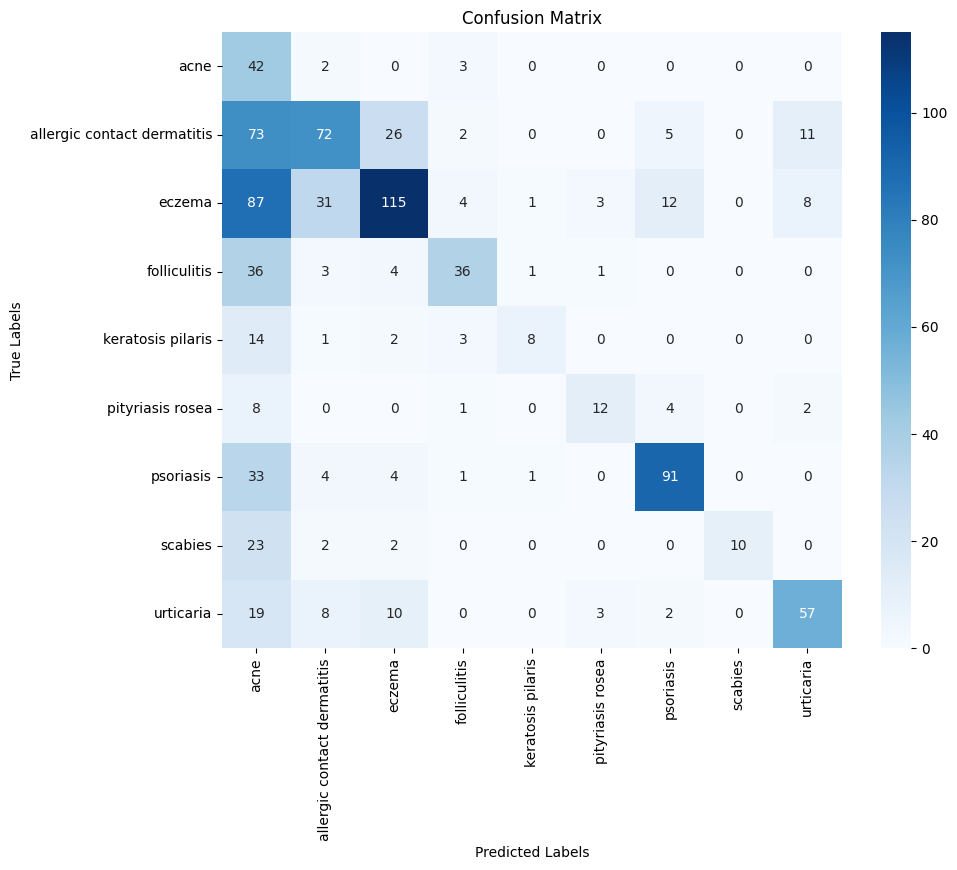

In [50]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming y_test and y_pred are already defined from your previous code

# Calculate the confusion matrix
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=mlb.classes_, yticklabels=mlb.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

plt.title("Confusion Matrix")
plt.show()


In [51]:
print(classification_report(y_test, y_pred, target_names=mlb.classes_))

                             precision    recall  f1-score   support

                       acne       0.85      0.70      0.77        47
allergic contact dermatitis       0.59      0.38      0.46       189
                     eczema       0.68      0.50      0.58       273
               folliculitis       0.74      0.47      0.57        86
          keratosis pilaris       0.82      0.26      0.39        35
           pityriasis rosea       0.71      0.47      0.57        32
                  psoriasis       0.82      0.67      0.74       148
                    scabies       0.91      0.26      0.41        38
                  urticaria       0.77      0.64      0.70       107

                  micro avg       0.72      0.51      0.59       955
                  macro avg       0.76      0.48      0.58       955
               weighted avg       0.72      0.51      0.59       955
                samples avg       0.50      0.51      0.50       955



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


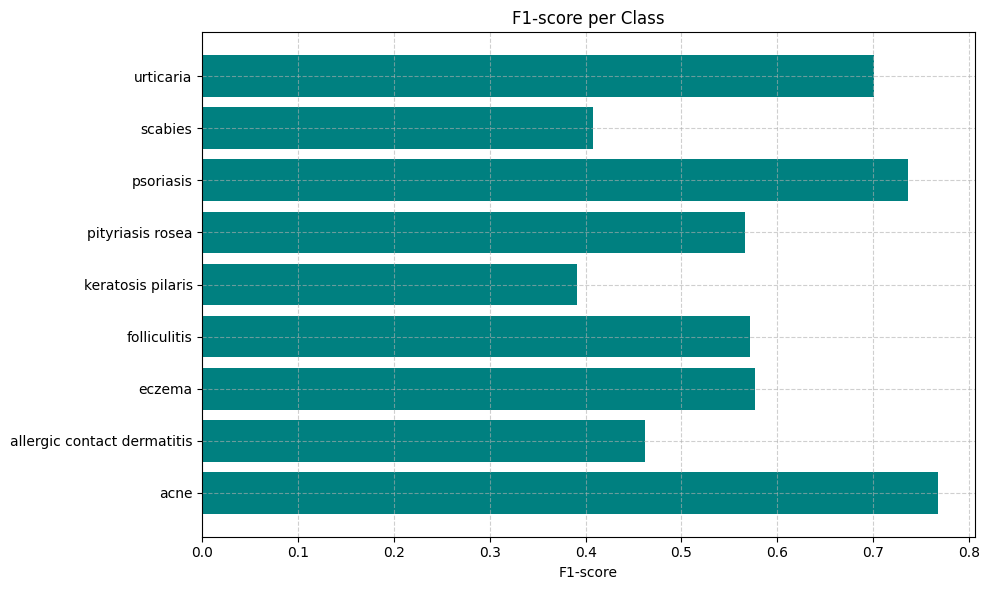

In [52]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_fscore_support

# Compute metrics
precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred)

# Plot F1-score
plt.figure(figsize=(10, 6))
plt.barh(mlb.classes_, f1, color='teal')
plt.xlabel("F1-score")
plt.title("F1-score per Class")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [53]:
import numpy as np
from sklearn.metrics import multilabel_confusion_matrix

# y_test and y_pred should be of shape (847, 9)
conf_matrices = multilabel_confusion_matrix(y_test, y_pred)

per_class_accuracy = []

for i, matrix in enumerate(conf_matrices):
    TN, FP, FN, TP = matrix.ravel()
    accuracy = (TP + TN) / (TP + FP + FN + TN)
    per_class_accuracy.append(accuracy)
    print(f"{mlb.classes_[i]}: {accuracy:.4f}")

acne: 0.9779
allergic contact dermatitis: 0.8140
eczema: 0.7785
folliculitis: 0.9336
keratosis pilaris: 0.9690
pityriasis rosea: 0.9745
psoriasis: 0.9214
scabies: 0.9679
urticaria: 0.9347


In [54]:
def print_hamming_loss(y_test, y_pred):
  y_bool = (y_pred >= 0.5).astype(int)
  print(f'\n### Hamming Loss: {hamming_loss(y_test, y_bool)} ###')

In [55]:
y_pred = model.predict_proba(X_test)
print_hamming_loss(y_test, y_pred)


### Hamming Loss: 0.08096468561584841 ###


In [65]:
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.multiclass import OneVsRestClassifier
from xgboost import XGBClassifier
import numpy as np
from sklearn.metrics import hamming_loss

def objective(trial):
    # Suggest hyperparameters
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 300),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "random_state": 42,
        "eval_metric": "logloss",
        "use_label_encoder": False,
        "verbosity": 1, 
        "device": 'cuda'
    }

    # Wrap XGB in OneVsRest for multilabel
    model = OneVsRestClassifier(XGBClassifier(**params))

    # Fit model on training data
    model.fit(X_train, y_train)

    # Predict probabilities
    y_prob = model.predict_proba(X_val)

    # Apply threshold to convert to binary predictions
    y_pred = (np.array(y_prob) >= 0.5).astype(int)

    # Compute Hamming Loss
    return hamming_loss(y_val, y_pred)  # minimize



In [68]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

[I 2025-06-27 12:18:37,545] A new study created in memory with name: no-name-fd56b778-7d82-48f5-a359-a1563a8e2f7e
[I 2025-06-27 12:19:11,111] Trial 0 finished with value: 0.0909510618651893 and parameters: {'n_estimators': 163, 'max_depth': 8, 'learning_rate': 0.010554679967924665, 'subsample': 0.8532363149456721, 'colsample_bytree': 0.5175322483900066, 'gamma': 0.7603637398308977, 'min_child_weight': 5}. Best is trial 0 with value: 0.0909510618651893.
[I 2025-06-27 12:19:39,014] Trial 1 finished with value: 0.08448753462603878 and parameters: {'n_estimators': 254, 'max_depth': 9, 'learning_rate': 0.17812420398979856, 'subsample': 0.649749961703054, 'colsample_bytree': 0.9704926804148423, 'gamma': 1.4629001296596895, 'min_child_weight': 3}. Best is trial 1 with value: 0.08448753462603878.
[I 2025-06-27 12:20:00,563] Trial 2 finished with value: 0.08618036318867343 and parameters: {'n_estimators': 97, 'max_depth': 6, 'learning_rate': 0.03363477275026366, 'subsample': 0.8659376075892291,

In [69]:
print("Best Hamming Loss:", study.best_value)
print("Best Params:", study.best_params)

Best Hamming Loss: 0.08033240997229917
Best Params: {'n_estimators': 293, 'max_depth': 8, 'learning_rate': 0.07053097876646924, 'subsample': 0.871540752674429, 'colsample_bytree': 0.6345002269032309, 'gamma': 0.5760259973214391, 'min_child_weight': 10}


# Training xgboost with tuned hyperparameters 

In [70]:
# Train final model on full training data
xgb_final_model = OneVsRestClassifier(XGBClassifier(**study.best_params))
xgb_final_model.fit(X_train, y_train)

OneVsRestClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.6345002269032309,
                                            device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            gamma=0.5760259973214391,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.07053097876646924,
                                            max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=8,
                                            max_leaves=None,
                                            min_child_weight=10, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=293, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...))

In [71]:
y_pred = xgb_final_model.predict(X_test)

In [72]:
# === EVALUATION METRICS ===
# Micro F1-score: Good for overall performance
micro_f1 = f1_score(y_test, y_pred, average='micro')

# Macro F1-score: Good for per-class performance (important for imbalanced data)
macro_f1 = f1_score(y_test, y_pred, average='macro')

# Precision & Recall
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')

# Jaccard Similarity (Intersection over Union)
jaccard = jaccard_score(y_test, y_pred, average='samples')

# Hamming Loss (Lower is better)
hamming = hamming_loss(y_test, y_pred)

# Print results
print("=== Evaluation Metrics ===")
print(f"Micro F1-score: {micro_f1:.4f}")
print(f"Macro F1-score: {macro_f1:.4f}")
print(f"Precision (Macro): {precision:.4f}")
print(f"Recall (Macro): {recall:.4f}")
print(f"Jaccard Similarity: {jaccard:.4f}")
print(f"Hamming Loss: {hamming:.4f} (Lower is better)")

=== Evaluation Metrics ===
Micro F1-score: 0.6177
Macro F1-score: 0.5808
Precision (Macro): 0.7731
Recall (Macro): 0.4790
Jaccard Similarity: 0.5127
Hamming Loss: 0.0749 (Lower is better)


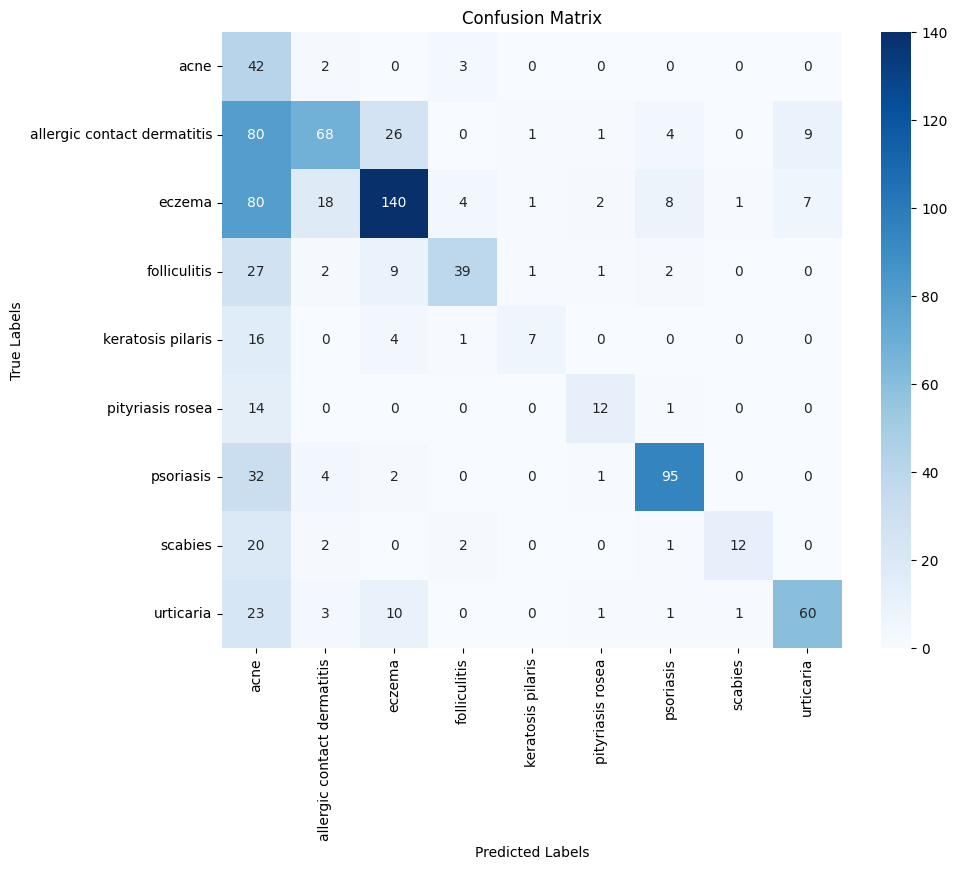

In [73]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming y_test and y_pred are already defined from your previous code

# Calculate the confusion matrix
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=mlb.classes_, yticklabels=mlb.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

plt.title("Confusion Matrix")
plt.show()


In [74]:
print(classification_report(y_test, y_pred, target_names=mlb.classes_))

                             precision    recall  f1-score   support

                       acne       0.74      0.62      0.67        47
allergic contact dermatitis       0.69      0.36      0.47       189
                     eczema       0.73      0.55      0.63       273
               folliculitis       0.84      0.50      0.63        86
          keratosis pilaris       0.75      0.26      0.38        35
           pityriasis rosea       0.72      0.41      0.52        32
                  psoriasis       0.86      0.68      0.76       148
                    scabies       0.80      0.32      0.45        38
                  urticaria       0.82      0.63      0.71       107

                  micro avg       0.77      0.52      0.62       955
                  macro avg       0.77      0.48      0.58       955
               weighted avg       0.77      0.52      0.61       955
                samples avg       0.53      0.53      0.52       955



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import optuna
import numpy as np
from sklearn.metrics import hamming_loss
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from lightgbm import LGBMClassifier

# Split dataset once for validation (faster than CV on CPU)
X_train_part, X_val_part, y_train_part, y_val_part = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

def objective(trial):
    # Define hyperparameter search space
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 300),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 15, 100),
        "min_child_samples": trial.suggest_int("min_child_samples", 10, 100),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 1.0),
        "random_state": 42,
        "n_jobs": -1,
        'device': 'gpu'
    }

    # Wrap in OneVsRest for multilabel support
    model = OneVsRestClassifier(LGBMClassifier(**params))

    # Fit the model
    model.fit(X_train, y_train)

    # Predict probabilities then threshold at 0.5
    y_prob = model.predict_proba(X_val)
    y_pred = (np.array(y_prob) >= 0.5).astype(int)

    # Compute and return Hamming Loss (minimize it)
    return hamming_loss(y_val, y_pred)

# Run Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=1)

# Print results
print("Best Hamming Loss:", study.best_value)
print("Best Hyperparameters:", study.best_params)


[I 2025-06-27 13:05:10,076] A new study created in memory with name: no-name-b4fc08cf-f3ce-41fb-ac44-746d201bf118


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Exception ignored on calling ctypes callback function: <function _log_callback at 0x7d0dfd3c2700>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py", line 287, in _log_callback
    def _log_callback(msg: bytes) -> None:
    
KeyboardInterrupt: 


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

Exception ignored on calling ctypes callback function: <function _log_callback at 0x7d0dfd3c2700>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py", line 287, in _log_callback
    def _log_callback(msg: bytes) -> None:
    
KeyboardInterrupt: 


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po